In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA, GradientDescent
import numpy as np
import matplotlib.pyplot as plt

#from qiskit_opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
#from qiskit import opflow
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library.data_preparation import Initialize
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import Operator, Statevector, DensityMatrix, random_statevector, partial_trace, random_unitary

from qiskit_aer import Aer, AerSimulator
from qiskit_aer import AerSimulator

from helper import get_most_likely_state, bin_state_to_grid_coordinates

sim = AerSimulator()

# grid_size*grid_size gridworld to navigate
grid_size = 4
num_states = grid_size * grid_size
num_qubits = int(np.ceil(np.log2(num_states)))  # minimum number of qubits to represent all the system's possible states

# starting point and goal
start_state = (0, 0)
goal_state = (1, 1)
start_state_binary = bin(start_state[0] * grid_size + start_state[1])[2:].zfill(num_qubits)
goal_state_binary = bin(goal_state[0] * grid_size + goal_state[1])[2:].zfill(num_qubits)

# Create a parameterized variational circuit
def create_variational_circuit(params):
    qc = QuantumCircuit(num_qubits)
    
    # Apply parameterized rotations (RX, RZ) to each qubit
    for i in range(num_qubits):
        qc.rx(params[i], i)
        qc.rz(params[num_qubits + i], i)

    # Add parameterized entangling gates (e.g., CNOT gates)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)

    return qc

# Number of parameters required for the circuit
num_params = 2 * num_qubits
params = [Parameter(f'theta_{i}') for i in range(num_params)]

# Initialize the circuit
variational_circuit = create_variational_circuit(params)
variational_circuit.measure_all()

# Initialize the state
initial_state = [0] * (2**num_qubits)
initial_state[int(start_state_binary, 2)] = 1
initialize_gate = Initialize(initial_state)
variational_circuit.append(initialize_gate, list(range(num_qubits)))

# Define a simple cost function to optimize (example: reward from a toy policy)
def cost_function(theta_values):
    backend = Aer.get_backend('qasm_simulator')
    #backend = Aer.get_backend()
    #qc = variational_circuit.bind_parameters(theta_values)
    qc = variational_circuit.assign_parameters({p: v for p, v in zip(variational_circuit.parameters, theta_values)})
    transpiled_qc = transpile(qc, backend)
    #job = execute(transpiled_qc, backend, shots=1024)
    job = sim.run(qc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    most_likely_state = get_most_likely_state(counts)
    row, col = bin_state_to_grid_coordinates(most_likely_state)

    # toy reward function
    #reward = counts.get(goal_state_binary, 0) / 1024
    if row == goal_state[0] and col == goal_state[1]:
        reward = 10
    else:
        reward = 100
    #reward = counts.get(goal_state_binary, 0)
    return -reward  # Minimizing negative reward

# Optimize the parameters using COBYLA
optimizer = COBYLA(maxiter=100, tol=1e-3)
#optimizer = GradientDescent(maxiter=1000, learning_rate=0.1)
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

result = optimizer.minimize(
    fun=cost_function,
    x0=initial_params
)

# Display the optimized parameters
optimized_params = result.x
print("Optimized Parameters:", optimized_params)
print("Optimized Cost:", result.fun)

Optimized Parameters: [0.76267411 2.88821451 2.28497725 5.41247107 3.41789588 5.14176227
 1.29468455 5.29946078]
Optimized Cost: -100.0


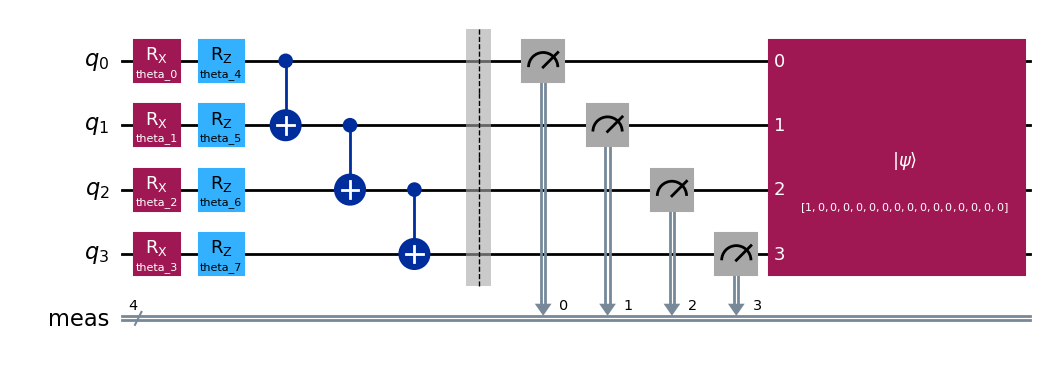

In [2]:
variational_circuit.draw('mpl')

In [2]:
sim = Aer.get_backend('statevector_simulator')

optimized_circuit = create_variational_circuit(optimized_params)
job = sim.run(optimized_circuit, shots=1024)
result = job.result()
counts = result.get_counts()
statevector = result.get_statevector()

best_state = get_most_likely_state(counts=counts)
row, col = bin_state_to_grid_coordinates(best_state)
print("Grid dimensions: %dx%d" % (grid_size, grid_size))
print("Starting point: ", start_state)
print("Goal point: ", goal_state)
print("Final point: (%d,%d)" % (row, col))

Grid dimensions: 4x4
Starting point:  (0, 0)
Goal point:  (1, 1)
Final point: (0,2)
